## Dependencies

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings, time
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn
from cassava_scripts import *
from scripts_step_lr_schedulers import *


seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
strategy, tpu = set_up_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 33
HEIGHT = 512
WIDTH = 512
HEIGHT_DT = 512
WIDTH_DT = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 10

# Load data

In [5]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord)
GCS_PATH_EXT = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-external-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External)
GCS_PATH_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) by classes
GCS_PATH_EXT_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-ext-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External) by classes


FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

# FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
# FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
# FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
# FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
# FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

# FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
# FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
# FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
# FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
# FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')


TRAINING_FILENAMES = (FILENAMES_COMP + FILENAMES_2019)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

Train samples: 21397
GCS: train images: 26335


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [6]:
def data_augment(image, label):
#     p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
#     # Shear
#     if p_shear > .2:
#         if p_shear > .6:
#             image = transform_shear(image, HEIGHT, shear=20.)
#         else:
#             image = transform_shear(image, HEIGHT, shear=-20.)
            
#     # Rotation
#     if p_rotation > .2:
#         if p_rotation > .6:
#             image = transform_rotation(image, HEIGHT, rotation=45.)
#         else:
#             image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [7]:
# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

In [8]:
# Datasets utility functions
def random_crop(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image, label

def center_crop_(image, label, height_rs, width_rs, height=HEIGHT_DT, width=WIDTH_DT, channels=3):
    image = tf.reshape(image, [height, width, channels]) # Original shape
    
    h, w = image.shape[0], image.shape[1]
    if h > w:
        image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
        
    image = tf.image.resize(image, [height_rs, width_rs]) # Expected shape
    return image, label

def get_dataset(filenames, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(filenames)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    
    if labeled:
        dataset = dataset.map(conf_output, num_parallel_calls=AUTO)
    
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def conf_output(image, label):
    """
        Configure the output of the dataset.
    """
    aux_label = [0.]
    if tf.math.argmax(label, axis=-1) == 4: # Healthy
        aux_label = [1.]
    return (image, (label, aux_label))

# Training data samples (with augmentation)

In [9]:
# train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
# train_iter = iter(train_dataset.unbatch().batch(20))

# display_batch_of_images(next(train_iter))
# display_batch_of_images(next(train_iter))

# Model

In [10]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB5(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')

    base_model.trainable = False

    x = L.Dropout(.25)(base_model.output)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    output_healthy = L.Dense(1, activation='sigmoid', name='output_healthy')(x)
    
    model = Model(inputs=inputs, outputs=[output, output_healthy])

    return model

### Learning rate schedule

13563 total steps and 411 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-06


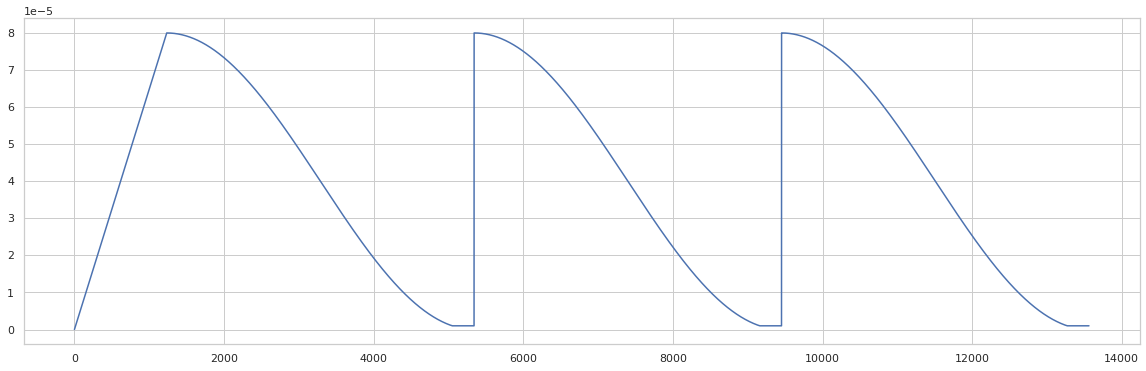

In [11]:
lr_start = 1e-8
lr_min = 1e-6
lr_max = LEARNING_RATE
num_cycles = 3.
warmup_epochs = 3
hold_max_epochs = 0
total_epochs = EPOCHS
step_size = (NUM_TRAINING_IMAGES//BATCH_SIZE)
hold_max_steps = hold_max_epochs * step_size
total_steps = total_epochs * step_size
warmup_steps = warmup_epochs * step_size


def lrfn(total_steps, warmup_steps=0, lr_start=1e-4, lr_max=1e-3, lr_min=1e-4, num_cycles=1.):
    @tf.function
    def cosine_with_hard_restarts_schedule_with_warmup_(step):
        """ Create a schedule with a learning rate that decreases following the
        values of the cosine function with several hard restarts, after a warmup
        period during which it increases linearly between 0 and 1.
        """

        if step < warmup_steps:
            lr = (lr_max - lr_start) / warmup_steps * step + lr_start
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
            if lr_min is not None:
                lr = tf.math.maximum(lr_min, float(lr))
        return lr
    return cosine_with_hard_restarts_schedule_with_warmup_

lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
rng = [i for i in range(total_steps)]
y = [lrfn_fn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {step_size} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Training

In [12]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; oof_names = []; oof_folds = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    FILENAMES_2019 = tf.io.gfile.glob([GCS_PATH_EXT + '/Id_train%.2i*.tfrec' % x for x in idxT])

#     FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
#     FILENAMES_2019_CBB = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CBSD = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_CGM = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_2019_Healthy = tf.io.gfile.glob([GCS_PATH_EXT_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])

    TRAIN_FILENAMES = (FILENAMES_COMP + FILENAMES_2019)
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps = (total_epochs * step_size)
    warmup_steps = (warmup_epochs * step_size)
    
    
    # Build TF datasets
    train_ds = strategy.experimental_distribute_dataset(get_dataset(TRAIN_FILENAMES, repeated=True, augment=True))
    valid_ds = strategy.experimental_distribute_dataset(get_dataset(VALID_FILENAMES, ordered=True, repeated=True))
    train_data_iter = iter(train_ds)
    valid_data_iter = iter(valid_ds)
    
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y[0], probabilities[0], label_smoothing=.3)
                aux_loss = aux_loss_fn(y[1], probabilities[1], label_smoothing=.1) * 0.1 # loss weight
                loss = loss + aux_loss
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            # update metrics
            train_accuracy.update_state(y[0], probabilities[0])
            train_aux_accuracy.update_state(y[1], probabilities[1])
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y[0], probabilities[0])
            aux_loss = aux_loss_fn(y[1], probabilities[1]) * 0.1 # loss weight
            loss = loss + aux_loss
            # update metrics
            valid_accuracy.update_state(y[0], probabilities[0])
            valid_aux_accuracy.update_state(y[1], probabilities[1])
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    
    # Model
    model_path = f'model_{fold}.h5'
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.SGD(learning_rate=lambda: lrfn_fn(tf.cast(optimizer.iterations, tf.float32)), 
                                   momentum=0.95, nesterov=True)
        loss_fn = losses.categorical_crossentropy
        aux_loss_fn = losses.binary_crossentropy

        train_accuracy = metrics.CategoricalAccuracy()
        valid_accuracy = metrics.CategoricalAccuracy()
        train_aux_accuracy = metrics.BinaryAccuracy()
        valid_aux_accuracy = metrics.BinaryAccuracy()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
        
        metrics_list = [train_accuracy, 
                        valid_accuracy, 
                        train_aux_accuracy, 
                        valid_aux_accuracy, 
                        train_loss, 
                        valid_loss]
    
    
    # Setup training loop
    step = 0
    epoch_steps = 0
    patience_cnt = 0
    best_val = 0
    history = {'loss': [], 'val_loss': [], 
               'accuracy': [], 'val_accuracy': [], 
               'accuracy_aux': [], 'val_accuracy_aux': []}

    ### Train model
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Run training step
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size
            

        # Validation run at the end of each epoch
        if (step // step_size) > epoch:
            # Validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # Compute metrics
            history['accuracy_aux'].append(train_aux_accuracy.result().numpy())
            history['accuracy'].append(train_accuracy.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE * epoch_steps))
            history['val_accuracy_aux'].append(valid_aux_accuracy.result().numpy())
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE * valid_epoch_steps))

            # Report metrics
            epoch_time = time.time() - epoch_start_time
            print(f'\nEPOCH {epoch+1}/{EPOCHS}')
            print(f'time: {epoch_time:0.1f}s',
                  f"loss: {history['loss'][-1]:0.4f}",
                  f"accuracy_aux: {history['accuracy_aux'][-1]:0.4f}",
                  f"accuracy: {history['accuracy'][-1]:0.4f}",
                  f"val_loss: {history['val_loss'][-1]:0.4f}",
                  f"val_accuracy_aux: {history['val_accuracy_aux'][-1]:0.4f}",
                  f"val_accuracy: {history['val_accuracy'][-1]:0.4f}",
                  f'lr: {lrfn_fn(tf.cast(optimizer.iterations, tf.int32).numpy()):0.4g}')

            # Early stopping monitor
            if history['val_accuracy'][-1] >= best_val:
                best_val = history['val_accuracy'][-1]
                model.save_weights(model_path)
                print(f'Saved model weights at "{model_path}"')
                patience_cnt = 1
            else:
                patience_cnt += 1
            if patience_cnt > ES_PATIENCE:
                print(f'Epoch {epoch:05d}: early stopping')
                break

                
            # Set up next epoch
            epoch_steps = 0
            for metric in metrics_list:
                metric.reset_states()
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_folds.append(np.full((ct_valid), fold, dtype='int8'))
    oof_labels.append([target[0].numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(np.argmax(model.predict(x_oof)[0], axis=-1))
    # OOF names
    ds_valid_names = get_dataset(VALID_FILENAMES, labeled=False, ordered=True)
    oof_names.append(np.array([img_name.numpy().decode('utf-8') for img, img_name in iter(ds_valid_names.unbatch())]))


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
115261440/115255328 [==============================] - 7s 0us/step

EPOCH 1/33
time: 198.4s loss: 1.3618 accuracy_aux: 0.8179 accuracy: 0.6296 val_loss: 0.7865 val_accuracy_aux: 0.8790 val_accuracy: 0.7947 lr: 2.667e-05
Saved model weights at "model_0.h5"

EPOCH 2/33
time: 57.8s loss: 1.1471 accuracy_aux: 0.8941 accuracy: 0.8162 val_loss: 0.6087 val_accuracy_aux: 0.9183 val_accuracy: 0.8572 lr: 5.334e-05
Saved model weights at "model_0.h5"

EPOCH 3/33
time: 59.0s loss: 1.1051 accuracy_aux: 0.9156 accuracy: 0.8487 val_loss: 0.6083 val_accuracy_aux: 0.9266 val_accuracy: 0.8700 lr: 8e-05
Saved model weights at "model_0.h5"

EPOCH 4/33
time: 59.7s loss: 1.0865 accuracy_aux: 0.9206 accuracy: 0.8653 val_loss: 0.5923 val_accuracy_aux: 0.9377 val_accuracy: 0.8786 lr: 7.804e-05
Saved model weights at "model_0.h5"

EPOCH 5/33
time: 58.6s loss: 1.0746 accuracy_aux: 0.9297 accuracy: 0.8720 val_loss: 0.5683 val_accuracy_aux: 0.932

## Model loss graph


FOLD: 1


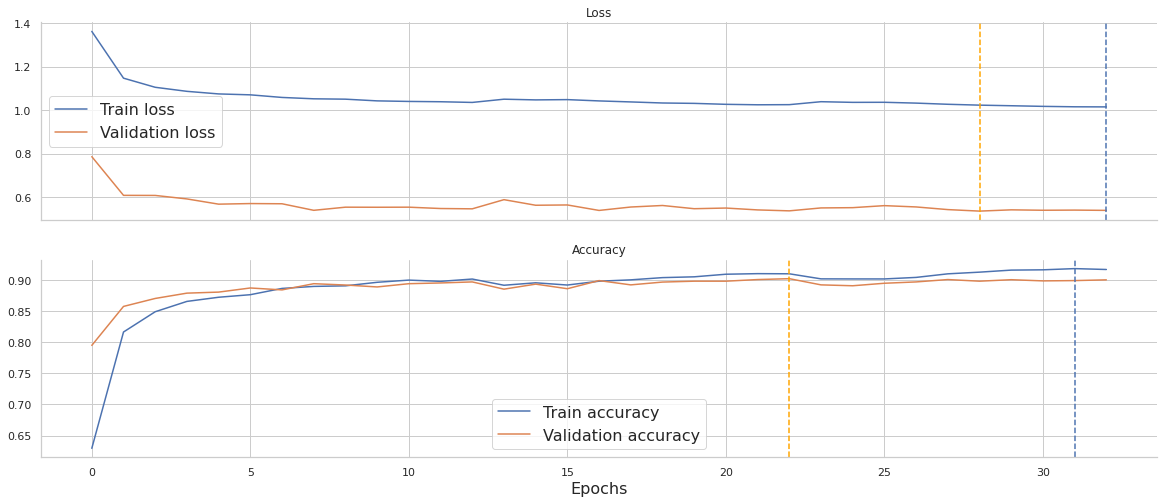


FOLD: 2


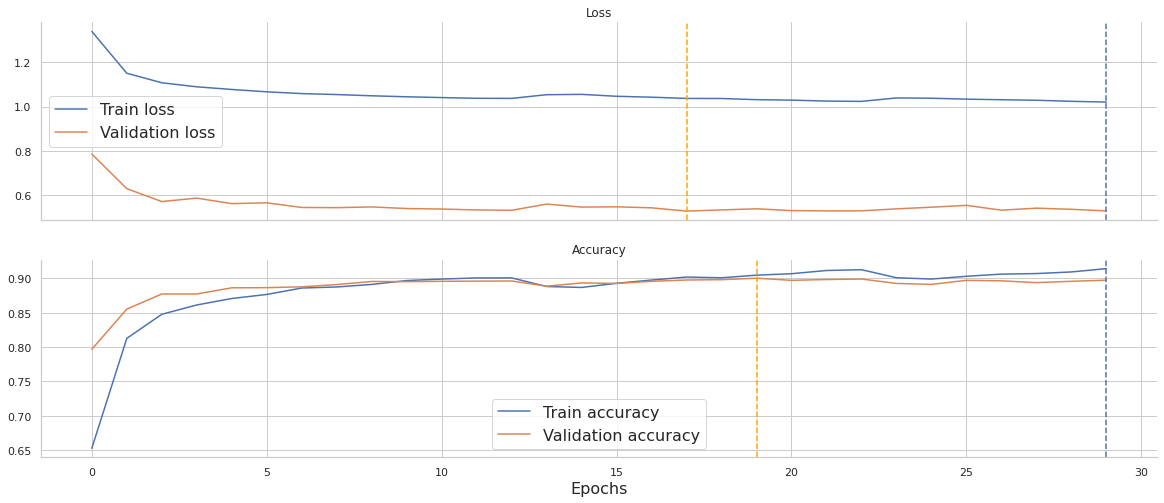


FOLD: 3


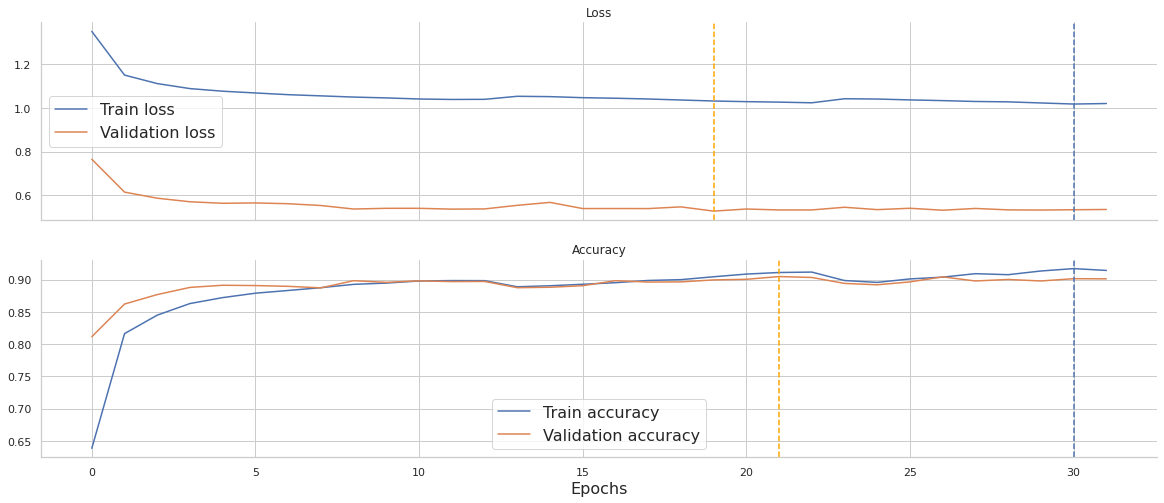


FOLD: 4


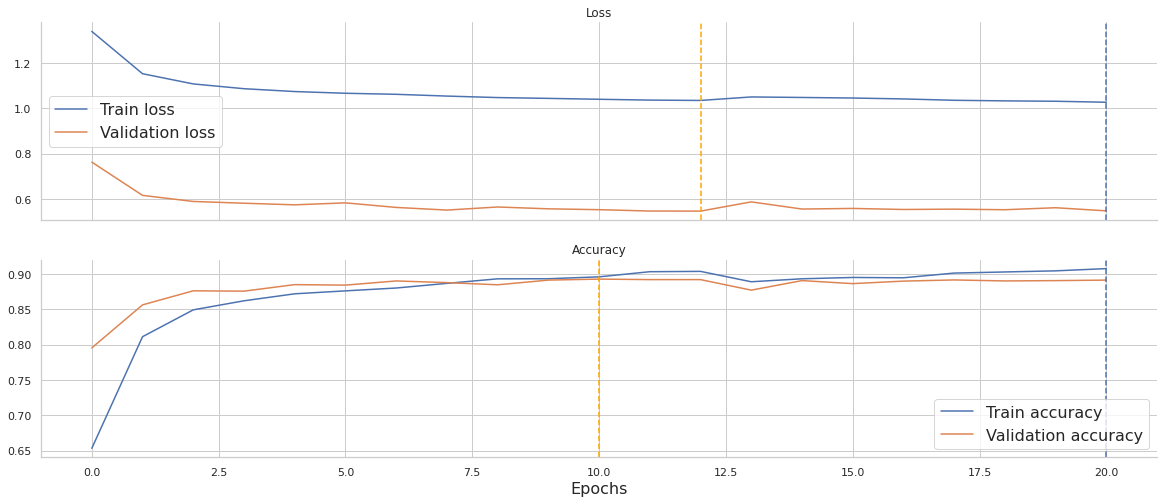


FOLD: 5


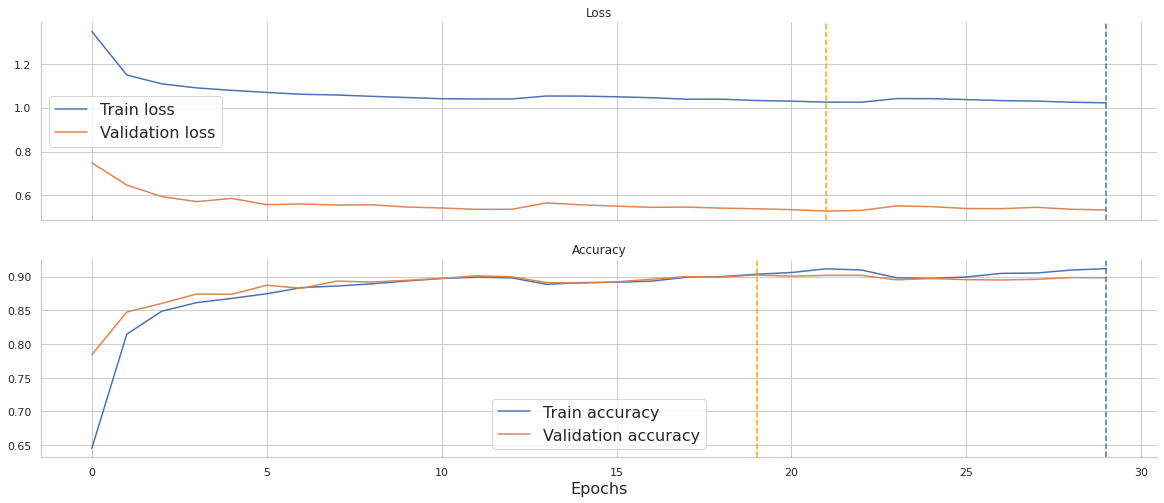

In [13]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

In [14]:
y_true = np.concatenate(oof_labels)
y_true = np.argmax(y_true, axis=-1)
y_pred = np.concatenate(oof_pred)
folds = np.concatenate(oof_folds)
names = np.concatenate(oof_names)

acc = accuracy_score(y_true, y_pred)
print(f'Overall OOF Accuracy = {acc:.3f}')

df_oof = pd.DataFrame({'image_id':names, 'fold':fold, 
                       'target':y_true, 'pred':y_pred})
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())

print(classification_report(y_true, y_pred, target_names=CLASSES))

Overall OOF Accuracy = 0.900


,image_id,fold,target,pred
0,1000201771.jpg,4,3,3
1,1000837476.jpg,4,3,3
2,1001723730.jpg,4,4,0
3,1001749118.jpg,4,3,3
4,1008284502.jpg,4,3,3


                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.68      0.71      0.69      1086
Cassava Brown Streak Disease       0.86      0.82      0.84      2189
        Cassava Green Mottle       0.84      0.81      0.82      2386
      Cassava Mosaic Disease       0.96      0.98      0.97     13158
                     Healthy       0.79      0.74      0.77      2576

                    accuracy                           0.90     21395
                   macro avg       0.82      0.81      0.82     21395
                weighted avg       0.90      0.90      0.90     21395



# Confusion matrix

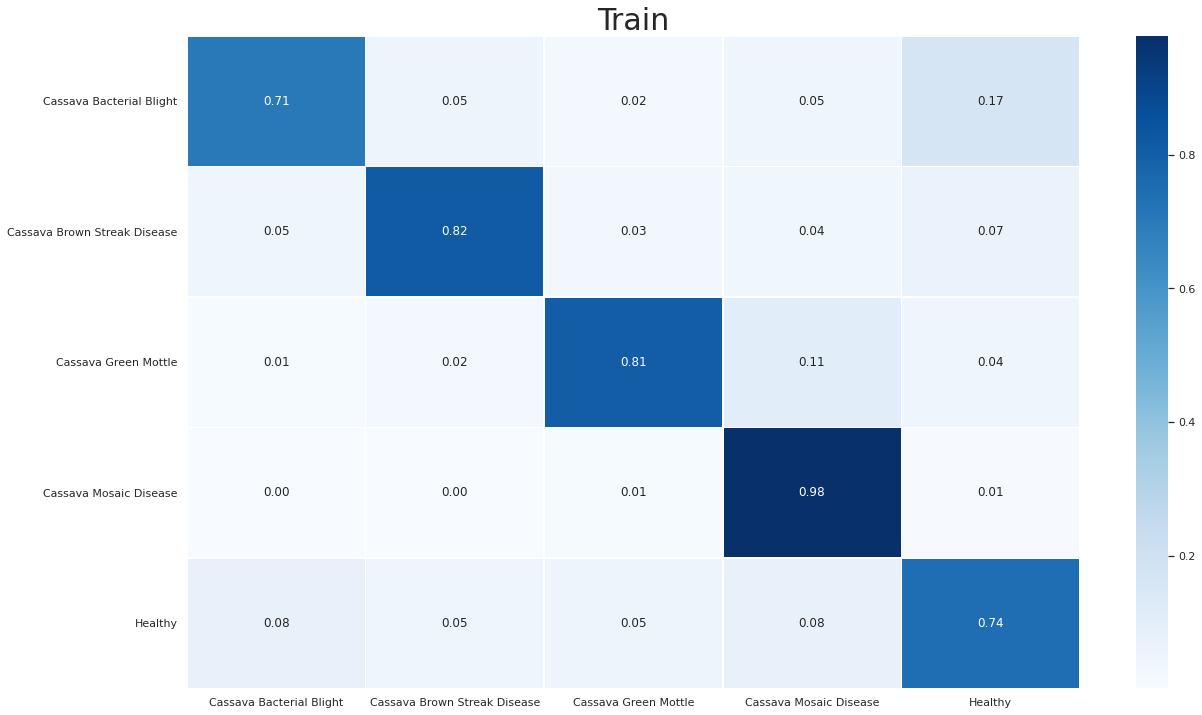

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize predictions

In [16]:
# train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
# x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
# y_samp = np.argmax(y_samp, axis=-1)

# x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
# samp_preds_1 = model.predict(x_samp_1, batch_size=9)
# display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

# x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
# samp_preds_2 = model.predict(x_samp_2, batch_size=9)
# display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)